In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from functools import partial
from scipy.optimize import minimize
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix
from Nexis_model_forward import run_Nexis
import seaborn as sns
from scipy.stats import pearsonr


## Preparing Inputs

In [2]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis due to errors in tau-PET imaging (CAN EDIT THIS)
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Define total number of subcortical regions and cortical regions per hemisphere
total_sub = 9 - len(regions_to_exclude)/2
total_cor = 34

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

In [219]:
# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

# Initial vector

# SET INITIAL VECTOR METHOD ('baseline' or 'binary')
init_vec_method = 'binary' 

# Conversion of ADNI region order to match connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']


# OPTION 1: Use baseline data from EBM tau time series
if init_vec_method == 'baseline':

    init_con = pandas.read_csv('Regional tau time series - version 1.csv')

    # Housekeeping
    init_con = init_con.drop('Unnamed: 0',axis=1)

    # Reorder regions to match region order of connectivity matrix
    init_con_reordered = init_con.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    columns_to_delete = init_con_reordered.columns[excluded_indices]
    init_con_excluded = init_con_reordered.drop(columns_to_delete, axis = 1)

    # Take the first row (time point 0) as initial vector
    init_vec = init_con_excluded.iloc[0].values

    # Set use_baseline NEXIS input to 1 to indicate use of baseline data as initial vector  
    use_baseline_ = 0 

#OPTION 2: Binary vector indicating seeding location 
if init_vec_method == 'binary':

    seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # MANUALLY EDIT SEEDING LOCATION HERE
    seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)

    # Set entries for seeding locations to 1 (both left and right hemisphere)
    init_vec[seeding_indices[0]] = 1 
    init_vec[seeding_indices[1]] = 1

    # Set use_baseline NEXIS input to 0 to indicate use of binary initial vector 
    use_baseline_ = 0 

In [187]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Reorder to match that of connectivity matrix
new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

In [188]:
# Run on either individual subjects (1) or whole cohort (0) (SET HERE)
individual = 1

In [220]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1))  # Don't care about cell types (nROI x nTypes), set to nROI x 1 array of random numbers or 0
init_vec_ = init_vec # Initial tau vector (nROI x 1)
if individual == 1:
    t_vec_ = np.linspace(0, 15, 16)
else:
    t_vec_ = np.linspace(0, 10, 100)  # Time vector (include 100 time points) (1 x nt)
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
degreecorrect_ = 0 # Binary flag indicating whether to normalize by degree (for Ashish, normally set this to 0)
logistic_term_ = 1 # Binary flag set to 1 to run with logistic term and 0 to run without

## Load EBM Data

In [221]:
if individual == 1:
    patient_data = pandas.read_csv('Cross-sectional stage and regional tau.csv')

    RID = 31 #EDIT PATIENT RID MANUALLY HERE
    patient = patient_data[patient_data['RID'] == RID] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]
    # LATER: DEFINE IN TERMS OF TIME WHERE TIME vs. STAGE RELAITONSHIP IS SIGNMOIDAL

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Reorder regions to match region order of connectivity matrix
    new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
    patient_tau = patient_tau.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

else:
    # Load tau time series from EBM (E(t)) to compare with NDM output (Y)
    EBM_data = pandas.read_csv('Regional tau time series - version 1.csv')

    # Housekeeping
    EBM_data = EBM_data.drop('Unnamed: 0',axis=1)

    # Convert to an nROI x 100 array and transpose
    EBM_data_array = EBM_data.values
    EBM_data_transposed = EBM_data_array.T

    # Reorder regions to match region order in NDM output
    new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
    EBM_data_reordered = EBM_data_transposed[new_order, :]

    # Delete striatal regions 
    EBM_data_excluded = np.delete(EBM_data_reordered, excluded_indices,axis = 0)

    # Normalize by L2 norm
    #normalized_EBM_data_excluded = normalize_by_l2_norm(EBM_data_excluded)

## Parameter Optimization

In [222]:
# Define cost function 
def Nexis_error(params, patient_tau):
    
    param1, param2, param3, param4, param5, param6, param7 = params 
    # param1 = alpha, param2 = beta, param3 = gamma, param4 = s, param5 = b, param6 = p, param7 =k
    
   # Initialize run_Nexis object 
    nexis_optimizing = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_ = logistic_term_)

    # Parameters for simulate_nexis method
    parameters = [param1, param2, param3, param4, param5, param6, param7]  # [alpha, beta, gamma, s, b, p , k] 

    # Call the simulate_nexis method with the parameters
    Y = nexis_optimizing.simulate_nexis(parameters)

    if individual == 1:
        # For optimization, only take stages from Y that correspond to patient's stages 
        Y_edited = Y[:, stages] 
        # Calculate R
        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
        error = mse_matrix(patient_tau, Y_edited) + 0.5 * (1- corr_coeff) 
    else:
        error = mse_matrix(EBM_data_excluded, Y)
    
    return error

In [223]:
custom_Nexis_error = partial(Nexis_error, patient_tau=patient_tau)

# Initial guesses for parameters (alpha, beta, gamma, s, b, p, k) # ADJUST THESE
init_guess = np.array([0.1, 1.01, 0.5, 0.5, 0, 0.0, 20])

# Bounds for each parameter [(min alpha, max alpha), (min beta, max beta), (min gamma, max gamma), etc. # ADJUST THESE
bounds = [(0, 2),(0, 3),(0,3),(0.5,0.5),(0,0),(0,0),(0,50)]

# Perform the optimization
result = minimize(custom_Nexis_error, init_guess, bounds=bounds, method='L-BFGS-B', 
                  options={'ftol': 1e-3, 'gtol': 1e-3,'maxiter': 1000})

# Check the results
if result.success:
    optimized_params = result.x
    optimized_params = optimized_params.tolist()
    print(f"Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): {optimized_params}")
else:
    print("Optimization failed.", result.message)

Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): [0.10675617340207058, 1.0294663175651761, 0.5026744828439624, 0.5, 0.0, 0.0, 19.999999444888534]


## Running Nexis

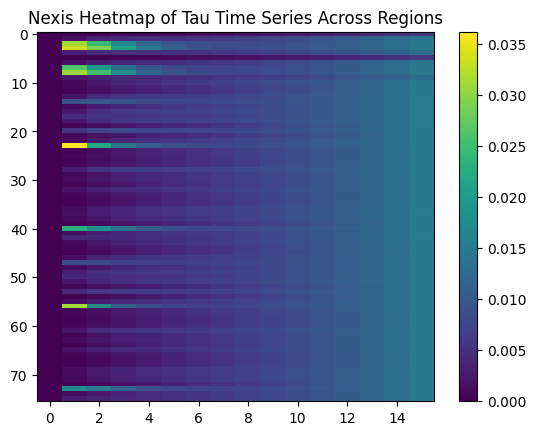

In [224]:
# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_=logistic_term_)

# Parameters for simulate_nexis method
parameters = optimized_params  # [alpha, beta, gamma, s, b, p, k] # CAN MANUALLY SET PARAMETERS HERE

# Call the simulate_nexis method with the parameters
Y = nexis_model.simulate_nexis(parameters)

if individual == 1:
    # Take stages from Y that correspond to patient's stages 
    Y_edited = Y[:, stages]
else:
    # Normalize by L2 norm
    normalized_Y = normalize_by_l2_norm(Y)

# Plot heatmap of Y
plt = heatmap(init_vec_method, Y)

## Check Results

In [225]:
# Calculate MSE between EBM data and Y
if individual == 1:
    mse = mse_matrix(patient_tau, Y_edited)
else:
    mse = mse_matrix(EBM_data_excluded, Y)
print('Mean squared error: ' + str(mse))

# Calculate R 
Y_edited = Y_edited.flatten() 
patient_tau = patient_tau.flatten() 
R, p_value = pearsonr(Y_edited, patient_tau)
print('Pearsons R: ' + str(R))

Mean squared error: 0.32929295843303524
Pearsons R: 0.02171104915210384


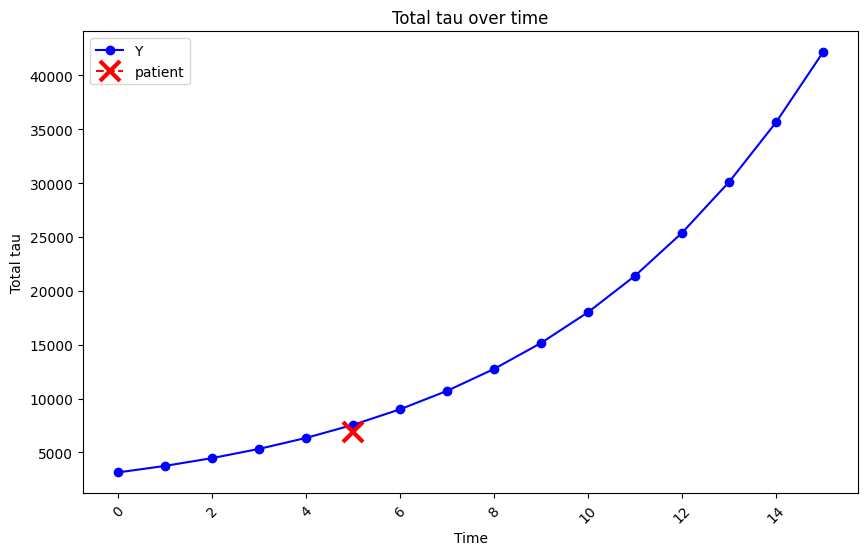

In [201]:
if individual == 1:
    # Volume correction
    regional_volumes_array = np.array(regional_volumes_excluded)
    regional_volumes_array = regional_volumes_array.reshape((78,1))
    tau_mass_Y = regional_volumes_array * Y
    total_tau_Y = np.sum(tau_mass_Y, axis=0)
    patient_tau = patient_tau.reshape(78,1)
    tau_mass_patient = regional_volumes_array * patient_tau
    total_tau_patient = np.sum(tau_mass_patient, axis=0)

    time_points_Y = np.linspace(0, 15, 16)

    plt.figure(figsize=(10, 6))

    # Plot total_tau_Y
    plt.plot(time_points_Y, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  

    # Plot total_tau_patient on the same graph
    plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='r', label= 'patient', markersize=15, markeredgewidth=3)

    plt.title('Total tau over time') 
    plt.xlabel('Time')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    plt.legend()  # Add a legend to distinguish the two lines

    # Show the plot
    plt.show
    
else:
    # Plot total tau over time to compare the scales of EBM and Y
    plt = total_tau_plot(Y, EBM_data_excluded, 'Y', 'EBM')
    plt.show

## Loop Through All Subjects 
If running on individuals

In [209]:
# Avoid repeating any RIDS
unique_rids = patient_data['RID'].unique()

#Create a data frame for all patients seeding patterns
column_names = ['RID', 'MSE', 'R', 'alpha', 'beta', 'gamma', 's', 'b', 'p', 'k']
parameters_all = pandas.DataFrame(columns=column_names)

for rid in unique_rids:

    patient = patient_data[patient_data['RID'] == rid] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Reorder regions to match region order of connectivity matrix
    patient_tau = patient_tau.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

    # Perform the optimization
    custom_Nexis_error = partial(Nexis_error, patient_tau=patient_tau)

    result = minimize(custom_Nexis_error, init_guess, bounds=bounds, method='L-BFGS-B', 
                    options={'ftol': 1e-3, 'gtol': 1e-3, 'maxiter': 1000})
    
    if result.success:
        optimized_params = result.x
        optimized_params = optimized_params.tolist()

    # Run Nexis    
    Y = nexis_model.simulate_nexis(optimized_params) 
    Y_edited = Y[:, stages]
    
    # Calculate MSE and R
    mse = mse_matrix(patient_tau, Y_edited)
    corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
    
    # Create data frame for the subject
    parameters = pandas.DataFrame([[rid] + [mse] + [corr_coeff] + optimized_params], columns=column_names)

    # Concatenate the original DataFrame with the new DataFrame
    parameters_all = pandas.concat([parameters_all, parameters], ignore_index=True)

parameters_all

/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Nexis_model_forward.py:103: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ode_func, y0, t_, args=(A_,Gamma_,k_))
/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_37106/934574235.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  parameters_all = pandas.concat([parameters_all, parameters], ignore_index=True)
/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Nexis_model_forward.py:103: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ode_func, y0, t

,RID,MSE,R,alpha,beta,gamma,s,b,p,k
0,21,0.056748,0.237479,0.482064,0.000000,0.507758,0.5,0.0,0.0,20.000383
1,31,0.305360,0.169823,0.246595,0.000000,0.401102,0.5,0.0,0.0,20.000315
2,56,0.198026,0.189101,0.176570,0.000000,0.553382,0.5,0.0,0.0,20.000023
3,59,0.192939,0.174799,0.290125,0.000000,0.565330,0.5,0.0,0.0,20.001177
4,69,0.027855,0.145605,0.100000,1.010000,0.521231,0.5,0.0,0.0,20.000000
...,...,...,...,...,...,...,...,...,...,...
647,6704,0.440170,0.166841,0.160346,0.000000,0.526788,0.5,0.0,0.0,19.999967
648,6705,1.002489,0.022211,0.190893,1.000568,0.519720,0.5,0.0,0.0,20.000004
649,6713,1.007067,0.001887,0.192792,0.999812,0.520111,0.5,0.0,0.0,20.000005
650,6721,0.993067,0.024307,0.218928,1.001296,0.525460,0.5,0.0,0.0,20.000008


In [210]:
# Add diagnosis and ml_stage information to data frame
parameters_all.insert(1, 'Diagnosis', patient_data['Diagnosis'])
parameters_all.insert(2, 'ml_stage', patient_data['ml_stage'])

# Save to a csv 
parameters_all.to_csv('Optimized param - final.csv')